# Rapid Adiabatic Passage Simulations for $\text{CO}$

In [1]:
# importing some paraphernelia 

import numpy as np
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='sans-serif', serif='computer modern')
import matplotlib.pyplot as plt

Also, the lifetime of an excited state $\tau$ and the corresponding einstein coefficient of the transition $A_{1\rightarrow 0}$ are related as,
$$
A_{1\rightarrow 0} = \frac{1}{\tau}.
$$
where $\tau$ is an experimentally, measurably quantity.

We can transition dipole moment from $A_{1\rightarrow 0}$ as,

$$
A_{1\rightarrow 0} = \frac{16\pi^3\bar{\nu}^3}{3\varepsilon_{0}h}\mu_{10}^{2}
$$

(For reference see, the textbook by Peter Bernath.)


In [2]:
from scipy.constants import epsilon_0, mu_0, h

def calc_dipole(A, nu_bar):
    """Calculates transition dipole matrix element mu_10 (C-m) for a transition with einstein coefficient A (s^{-1}) and, correspdoning wavenumber nu_bar (cm^-1)
    """
    const = 16*np.pi**3/(3*epsilon_0*h)    
    nu_bar = 100*nu_bar
    mu_10 = np.sqrt(A/(const*nu_bar**3))
    return mu_10

In [3]:
A10 = 50.61
dipole = calc_dipole(A10, nu_bar=2142.719943)
print("Dipole moment of the CO molecule : %8.6E C-m"%dipole)
print('(OR) %6.2f D'%(dipole/(3.33564*1E-30)))

Dipole moment of the CO molecule : 4.272167E-31 C-m
(OR)   0.13 D


In [4]:
!export OMP_NUM_THREADS=4
from rap_mb.helpers import *
from rap_mb.cpp import * 

In [5]:
# setting all constant parameters
input = {
        "wavelength_nm": 4666.0,
        "beam_radius": 0.20,
        "dipole_mom": dipole,
        "delta_v": 5.0,
        "angular_divg": 0.250,
        "N_samples": 1000.0,
        "N_tstep": 500.0,
        "U0": 0.0,
        "V0": 0.0,
        "W0": -1.0,
        "rel_tol":1e-8,
        "abs_tol":1e-8,
        "max_tsteps":10000,
        "dt_max":1.0e-5,
}

In [6]:
Nz = 40
input['velocity'] = 1200.00
input['power'] = 0.020
focal_length = np.array([15.0, 18.0, 20.0, 22.0, 24.0]) 
z = np.linspace(0.1, 30.0, Nz)
data1 = {'z': z}
focal_length_data = {}
for f in focal_length:
    input['focal_length'] = f
    n1 = np.empty(Nz, dtype=np.float64)
    for i in range(Nz):
        input['zi'] = z[i]
        n1[i] = calculate_ensemble_average(input)
    focal_length_data[f] = n1
data1['focal_length'] = focal_length_data 

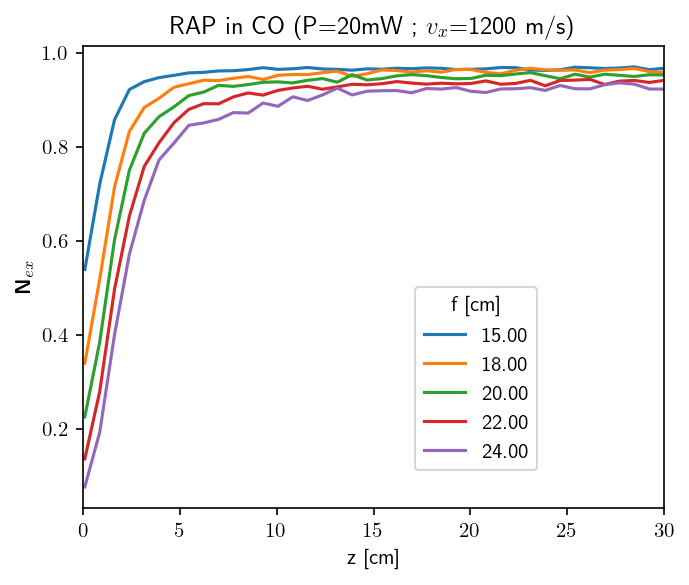

In [7]:
title = "RAP in CO (P=20mW ; $v_{x}$=1200 m/s)"
fig, ax = plot_property_data(data1, x_key='z', param_key='focal_length',
                             title=title, legend_title='f [cm]', 
                             xlabel='z [cm]',xlim=[0, 30])

In [8]:
fname = "../data/carbon_monoxide/p_2e-2_v_1200_f_fxn_z.npy"
np.save(fname, data1)

In [9]:
Np = 40
input['focal_length'] = 18.0
input['velocity'] = 1200.00
power = np.linspace(0.0, 0.050, Np)
data2 = {'power': power*1000}
power_data = {}
z = np.array([0.1, 1.25, 2.5, 5.0, 7.5, 10.0])
for zi in z:
    input['zi'] = zi
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[zi] = n1
data2['z'] = power_data

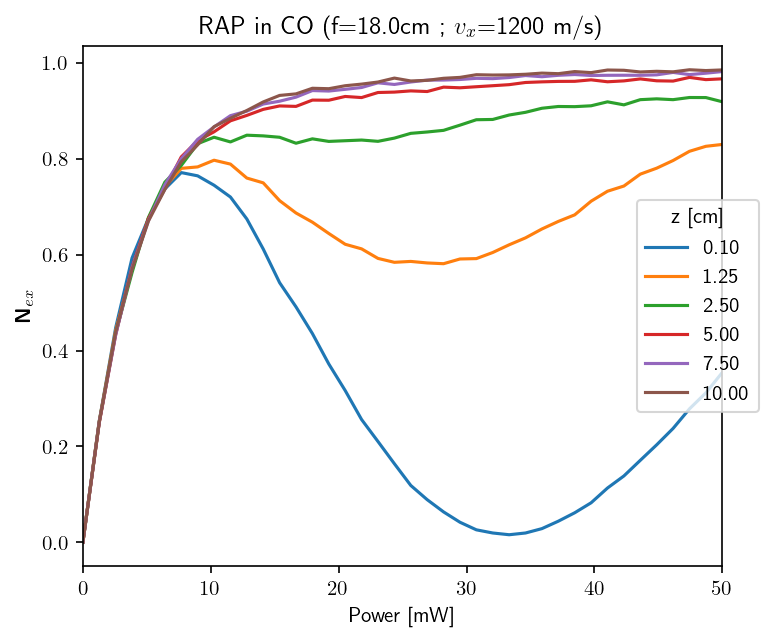

In [10]:
title = "RAP in CO (f=18.0cm ; $v_{x}$=1200 m/s)"
fig, ax = plot_property_data(data2, x_key='power', param_key='z',
                             title=title, legend_title='z [cm]', 
                             xlabel='Power [mW]',xlim=[0, 50],
                             figsize=(5.5,4.5), legend_loc=[0.85,0.5])

In [11]:
fname = "../data/carbon_monoxide/f_18_v_1200_z_fxn_p.npy"
np.save(fname, data2)

In [12]:
Np = 40
input['focal_length'] = 18.0
input['zi'] = 10.0
power = np.linspace(0.0, 0.100, Np)
data3 = {'power': power*1000}
power_data = {}
velocities = [1000, 1200, 1500, 1800, 2000, 2400, 2500]
for v in velocities:
    input['velocity'] = v
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[v] = n1
data3['velocity'] = power_data

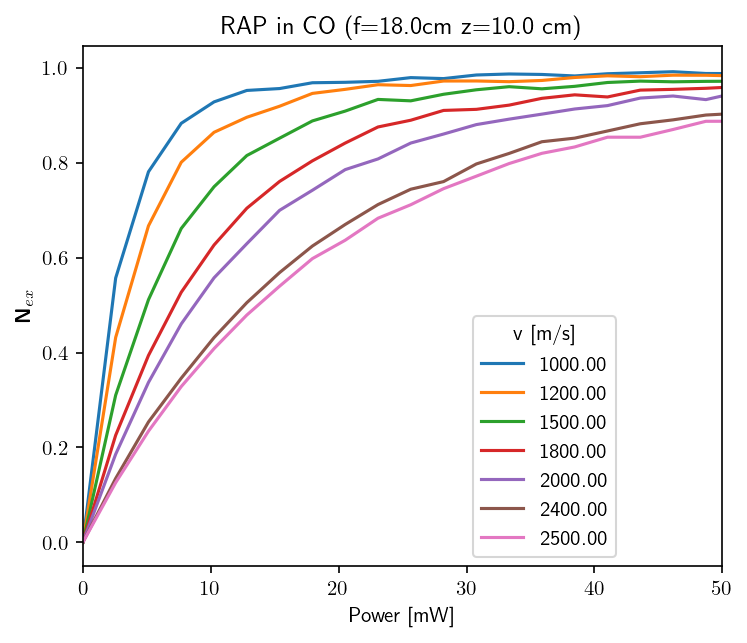

In [13]:
title = "RAP in CO (f=18.0cm z=10.0 cm)"
fig, ax = plot_property_data(data3, x_key='power', param_key='velocity',
                             title=title, legend_title=r'v [m/s]', 
                             xlabel='Power [mW]',xlim=[0, 50],
                             figsize=(5.5,4.5), legend_loc=[0.85,0.5])

In [14]:
fname = "../data/carbon_monoxide/f_18_z_10_v_fxn_p.npy"
np.save(fname, data3)

In [15]:
Np = 40
input['focal_length'] = 15.0
input['zi'] = 10.0
power = np.linspace(0.0, 0.100, Np)
data4 = {'power': power*1000}
power_data = {}
velocities = [1000, 1200, 1500, 1800, 2000, 2400, 2500]
for v in velocities:
    input['velocity'] = v
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[v] = n1
data4['velocity'] = power_data

In [ ]:
title = "RAP in CO (f=15.0cm z=10.0 cm)"
fig, ax = plot_property_data(data4, x_key='power', param_key='velocity',
                             title=title, legend_title=r'v [m/s]', 
                             xlabel='Power [mW]',xlim=[0, 50],
                             figsize=(5.5,4.5), legend_loc=[0.85,0.5])
ax.set_ylim(-0.025,1.05)

In [ ]:
fname = "../data/carbon_monoxide/f_15_z_10_v_fxn_p.npy"
np.save(fname, data4)